# Create a monochrome version of MNIST 
by spliting the MNIST into 4 subsets

Change the background (or digit's whitespace?) color to 
- keep as is (Black)
- Red
- Green
- Blue

The resulting dataset will consists of 4 subdatasets each of which has its own "style" (ie. the color of the background).


## Load libraries

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import os,sys
import re
import math
from datetime import datetime
import time
sys.dont_write_bytecode = True

In [ ]:
import pandas as pd

import numpy as np
import joblib
import matplotlib.pyplot as plt

from pathlib import Path
from typing import Any, List, Set, Dict, Tuple, Optional, Iterable, Mapping, Union, Callable, TypeVar

from pprint import pprint
from ipdb import set_trace as brpt

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from  torch.linalg import norm as tnorm
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import datasets, transforms

import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.tuner.tuning import Tuner


# Select Visible GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## Set Path 
1. Add project root and src folders to `sys.path`
2. Set DATA_ROOT to `maptile_v2` folder

In [ ]:
this_nb_path = Path(os.getcwd())
ROOT = this_nb_path.parent
SRC = ROOT/'src'
DATA_ROOT = Path("/data/hayley-old/maptiles_v2/")
paths2add = [this_nb_path, ROOT]

print("Project root: ", str(ROOT))
print('Src folder: ', str(SRC))
print("This nb path: ", str(this_nb_path))


for p in paths2add:
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))
        print(f"\n{str(p)} added to the path.")
# print(sys.path)

In [ ]:
from src.data.datamodules.maptiles_datamodule import MaptilesDataModule

from src.data.transforms.transforms import Identity, Unnormalizer, LinearRescaler, Monochromizer
from src.data.transforms.functional import unnormalize, to_monochrome

from src.visualize.utils import show_timg, show_timgs, show_batch, make_grid_from_tensors
from src.utils.misc import info
from collections import OrderedDict, defaultdict
from PIL import Image

In [ ]:
def to_monochrome(x: torch.Tensor,
                  color: str) -> torch.Tensor:
    """
    Transfrom a grayscale (3dim, (1,h,w) tensor) to a mono-chrome 3channel tensor (3,h,w) 
    x: a single 3dim torch.Tensor a single channel; (1, h, w)
    color: str - one of ['red', 'green', 'blue']
    
    returns:
    - a single (3dim) torch.Tensor with 3 channels: (3, h, w)
    
    """
    color2dim = {"red": 0, "green": 1, "blue": 2}
    
    color = color.lower()
    color_dim = color2dim[color]
    
    out = torch.zeros_like(x).repeat((3,1,1))
    print(out.shape)
    out[color_dim] = x
    return out

def test_to_monochrome(x: torch.Tensor):
    """
    x: a single 1-channel tensor (1, h, w)
    """
    timg = transforms.ToTensor()(x)
    timg.shape
    timg_r = to_monochrome(timg, 'red')
    timg_r.shape
    show_timg(timg_r)
    
def test_monochromizer(x: torch.Tensor):
    """
    x: a single 1-channel tensor (1, h, w)
    """
    timg = transforms.ToTensor()(x)
    timg_red = Monochromizer("red")(timg)
    show_timg(timg_red)


In [ ]:
def color_grayscale_arr(nparr: np.ndarray, color: str) -> np.ndarray:
    """
    - nparr: unit8 in range [0,255]; shape (28,28); 2dim
    
    Returns: np.ndarray of (h,w,3); float32; range (0., 1.0)
    """
    color = color.lower()
    assert color in ['r', 'g','b'], "color must be one of 'r', 'g','b'"
    assert nparr.ndim == 2
    h,w = nparr.shape
    nparr = nparr[...,None] # (h,w,1)
    
    if color == 'r':
        nparr = np.concatenate([nparr, np.zeros((h,w,2))],
                               axis=-1)
    elif color == 'g':
        nparr = np.concatenate([np.zeros((h,w,1)), nparr, np.zeros((h,w,1))],
                                axis=-1)
    else: #blue
        nparr = np.concatenate([np.zeros((h,w,2)), nparr],
                               axis=-1)
    return nparr #(h,w,3)

def test_color_grayscale_arr(img: Image):
    arr = np.array(img)
    r_img = color_grayscale_arr(arr, 'r')
    g_img = color_grayscale_arr(arr, 'g')
    b_img = color_grayscale_arr(arr, 'b')

    f,ax = plt.subplots(1,4)
    ax = ax.flatten()
    ax[0].imshow(arr, cmap='gray')
    ax[1].imshow(r_img)
    ax[2].imshow(g_img)
    ax[3].imshow(b_img)
    
    info(r_img)
test_color_grayscale_arr(X_r[0])

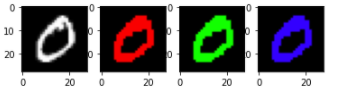


In [ ]:
MNIST_DATA_DIR = Path('/data/hayley-old/digits/')/'mnist'
ds = datasets.MNIST('/data/hayley-old/Tenanbaum2000/data/', train=True)
digits = defaultdict(list)
for i in range(len(ds)):
    x,y = ds[i] #PIL.Image of mode 'L' (ie. grayscale); y is int
    digits[y].append(x)
for k,v in digits.items():
    print(k, len(v))
    

For each digit class's collection of images (eg. all images of digit id = 0),
- random_spilt into number of colors/styles 


In [ ]:
seed = 123
dict_bw = defaultdict(list)
dict_r = defaultdict(list)
dict_g = defaultdict(dict)
dict_b = defaultdict(dict)

for digit, imgs in digits.items():
    
    n = len(imgs)
    n_color = n//4
    n_bw = n - 3*n_color
    bw_imgs, r_imgs, g_imgs, b_imgs = random_split(imgs,
                                                   [n_bw, n_color, n_color, n_color], 
                                                   generator=torch.Generator().manual_seed(seed))
    # bw/r/g/b: list of pil images -- each dataset has same digit id; different styles (either grayscale, red, green, blue)

    print("Digit id: ", digit)
    print("\t", [len(i) for i in [bw_imgs, r_imgs, g_imgs, b_imgs]])
    
    dict_bw[digit] = bw_imgs
    dict_r[digit] = r_imgs
    dict_g[digit] = g_imgs
    dict_b[digit] = b_imgs
    
    



Create each style's digit dataset from the dict of bw/r/g/b imgs
- Returns: bw_ds, r_ds, g_ds, b_ds

In [ ]:
def dict_imgs2tuple_xy(dict_imgs: Dict[int, List],
                      verbose=False) -> Tuple[Iterable, Iterable]:
    pil_imgs = []
    ys = []
    for k,v in dict_imgs.items():
        n_imgs = len(v)
        pil_imgs.extend(v)
        ys.extend([k]*n_imgs)
        
        if verbose:
            print("\n", k)
            print(len(pil_imgs), len(ys))
        
    return (pil_imgs, ys)
              
        

In [ ]:
X_bw,Y_bw = dict_imgs2tuple_xy(dict_bw)
X_r,Y_r = dict_imgs2tuple_xy(dict_r)
X_g,Y_g = dict_imgs2tuple_xy(dict_g)
X_b,Y_b = dict_imgs2tuple_xy(dict_b)

In [ ]:
def XY(name):
    return {
        "bw": (X_bw,Y_bw),
        "red": (X_r,Y_r),
        "green": (X_g,Y_g),
        "blue": (X_b,Y_b)
    }[name]

In [ ]:
out_root = Path('/data/hayley-old/Tenanbaum2000/data/Mono-MNIST/')
for name in ['bw', 'red', 'green', 'blue']:
    out_fn = out_root/f"mnist_{name}.pkl"
    joblib.dump(XY(name), out_fn)

In [ ]:
name = 'red'
ds = joblib.load(out_root/f"mnist_{name}.pkl")
ds[0]
                 

In [ ]:
def make_mnist_color_dataset(data_root: Union[Path, str], 
                             color: str):
    # Load preprocessed pickle
    pil_imgs, ys = joblib.load(data_root/f"mnist_{color}.pkl")
    print(len(pil_imgs), len(ys))
    breakpoint()
    
    # Make a dataset object
    Dataset(

In [ ]:
class MonoMNIST(Dataset):
    """
    - data_root: root dir that contains "mnist_{color}.pkl" files
    - color: str; one of "red", "green", "blue" 
    """
    def __init__(
        self,
        data_root: Union[Path,str],
        color: str,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,                 
    ):
        super().__init__()
        self.color = color.lower()
        assert self.color in ["red", "green", "blue"], "color must be one of red, green, blue"
        
        if transform is None:
            self.transform = transforms.Compose([transforms.ToTensor(), Monochromizer(self.color)])
        else:
            self.transform = transform
        self.target_transform = target_transform
        
        fn = Path(data_root)/f"mnist_{self.color}.pkl"
        self.data, self.targets = joblib.load(fn)
        
        
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (pil_image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index]) 
        #img is a PIL Image of mode ('L'); unit8 in [0,...,255]; shape (28,28)

        if self.transform is not None: #always perform the required basic transforms (ie. to Tensor and monochromizer)
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target
    
    
    def __len__(self) -> int:
        return len(self.data)
    
    def name(self) -> str:
        return f"MNIST-{self.color}"
    

---
## Test MonoMNIST dataset
Jan 5, 2021

In [ ]:
from src.data.datasets.mono_mnist import MonoMNIST

In [ ]:
GrayMNIST = MonoMNIST(data_root=ROOT/'data/Mono-MNIST',
                      color='gray',
                      train=True)

RedMNIST = MonoMNIST(data_root=ROOT/'data/Mono-MNIST',
                    color='red',
                    train=True)
GreenMNIST = MonoMNIST(data_root=ROOT/'data/Mono-MNIST',
                    color='green',
                      train=True)
BlueMNIST = MonoMNIST(data_root=ROOT/'data/Mono-MNIST',
                    color='blue',
                     train=True)

In [ ]:
for ds in [GrayMNIST, RedMNIST, GreenMNIST, BlueMNIST]:
    print(ds.name(), len(ds))
    for i in range(3):
        x,y = ds[i]
        show_timg(x)
        plt.title(y)
        plt.show()

---

## Test MonoDatamodule for each color

In [ ]:
from src.data.datamodules import MonoMNISTDataModule
in_shape = (3,32,32)
batch_size=16
color = 'red'

dm = MonoMNISTDataModule(
    data_root=Path('/data/hayley-old/Tenanbaum2000/data/Mono-MNIST/'),
    color=color,
    seed=123,
    in_shape=in_shape,
    batch_size=batch_size
)

In [ ]:
dm.setup('fit')


In [ ]:
dm.n_train, dm.n_val


In [ ]:
ds =dm.val_ds
for i in range(3):
    x,y = ds[i]
    show_timg(x)
    plt.title(y)
    plt.show()

In [ ]:
x,y = next(iter(dm.train_dataloader()))
x.shape, y.shape

In [ ]:
a

In [ ]:
show_timgs(x)

In [ ]:
for color in ['red']:#['gray', 'red', 'green', 'blue']:
    dm = MonoMNISTDataModule(
        data_root=Path('/data/hayley-old/Tenanbaum2000/data/Mono-MNIST/'),
        color=color,
        seed=123,
        in_shape=in_shape,
        batch_size=batch_size
    )
    dm.setup('fit')
    show_batch(dm) 
    plt.show()

---
- Can I append a new `transform` (Callable) to a list of `transform`s wrapped in `transform.Compose`?
  - Yes: use `transforms.Compose` again and pass in the composed transform as one
  of the inputs to the function


In [ ]:
xform = transforms.Compose([
transforms.ToTensor()])


In [ ]:
# xform.append(transforms.CenterCrop(10))

In [ ]:
xform = transforms.Compose([transforms.ToTensor()])


In [ ]:
xform2 = transforms.Compose([
    xform,
    transforms.CenterCrop(10)
])

In [ ]:
xform2


In [ ]:
datasets = []
for i in range(3):
    datasets.append(TensorDataset(torch.arange(i*10, (i+1)*10)))

dataset = ConcatDataset(datasets)
loader = DataLoader(
    dataset,
    shuffle=False,
    num_workers=0,
    batch_size=2
)

for data in loader:
    print(data)